Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing from Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Importing LightGBM
import lightgbm as lgb

# Importing from CatBoost
from catboost import CatBoostRegressor

In [2]:
# Loading car_data and printing its .info *aswell as its description
car_data = pd.read_csv('/datasets/car_data.csv')
print(car_data.info())
print(car_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Some obvious outliers in the data. I think Mileage might be okay? There could be a 150,000+ option for mileage on the app as the highest.

count    352593.000000
mean       2003.281398
std           6.890340
min        1971.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64


<AxesSubplot:>

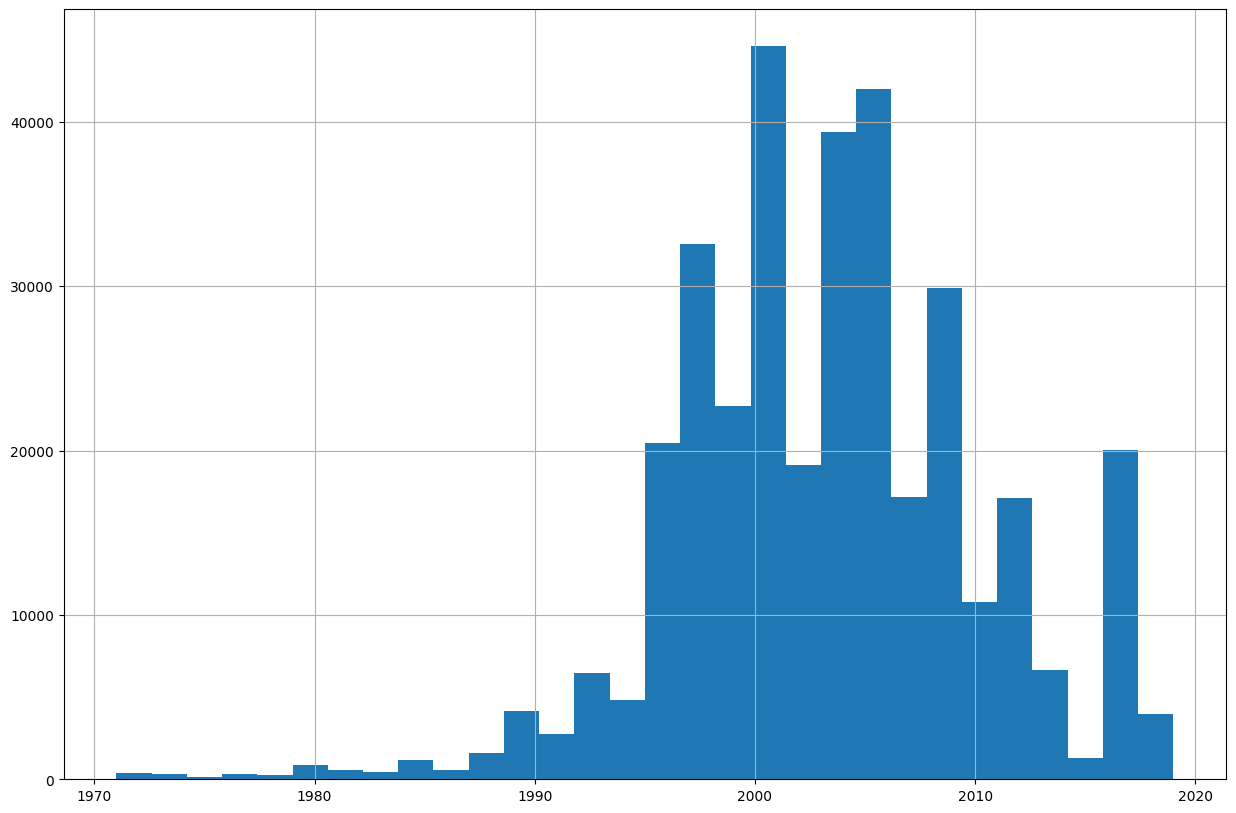

In [3]:
# Removing obvious outliers from 'RegistrationYear'

car_data = car_data[(car_data['RegistrationYear'] <= 2024) & (car_data['RegistrationYear'] > 1970)]

print(car_data['RegistrationYear'].describe())

car_data['RegistrationYear'].hist(bins=30, figsize=(15, 10))

count    352593.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

0         False
1         False
2         False
3         False
4         False
          ...  
354364    False
354365    False
354366    False
354367    False
354368    False
Name: NumberOfPictures, Length: 352593, dtype: bool


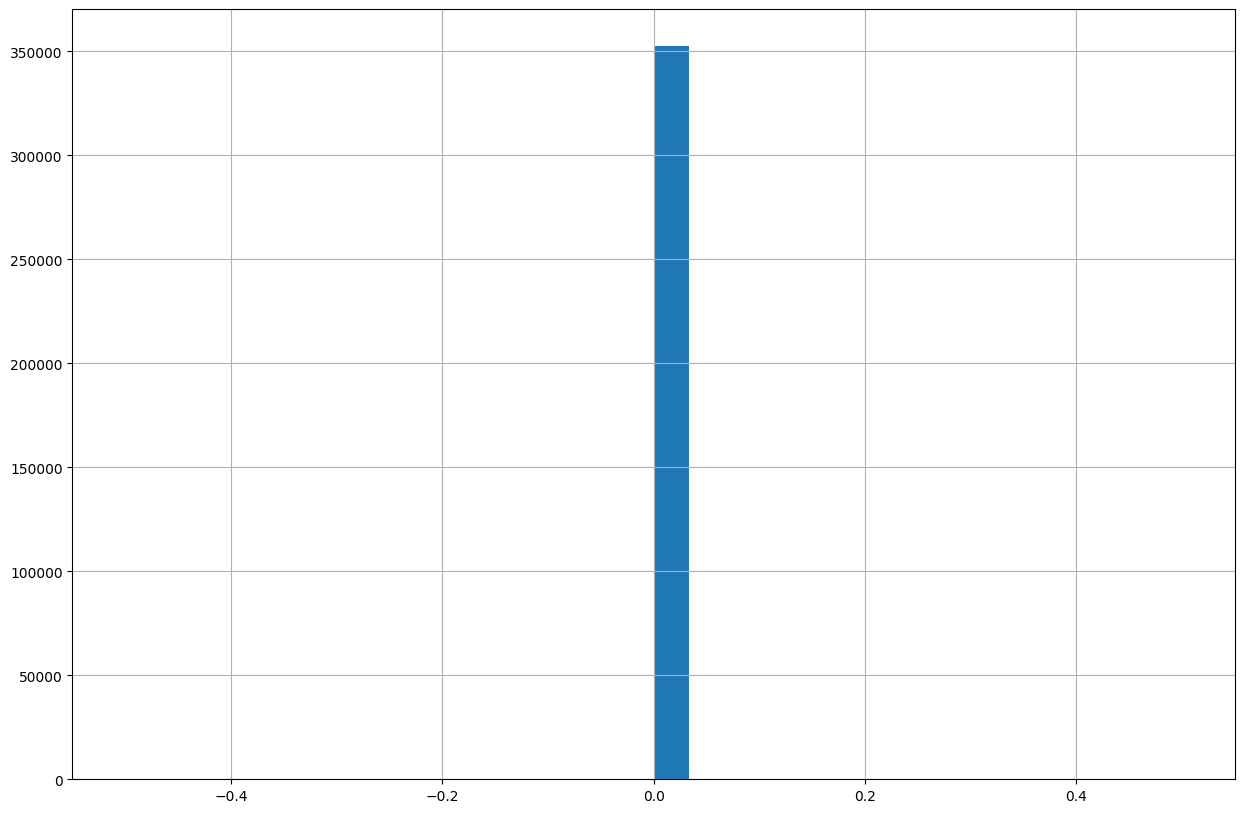

In [4]:
# Checking what's going on with 'NumberOfPictures'

print(car_data['NumberOfPictures'].describe())
print()

car_data['NumberOfPictures'].hist(bins=30, figsize=(15, 10))

print(car_data['NumberOfPictures'] > 0)

There's just nothing in here I guess

count    315846.000000
mean          6.391960
std           3.350012
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64


<AxesSubplot:>

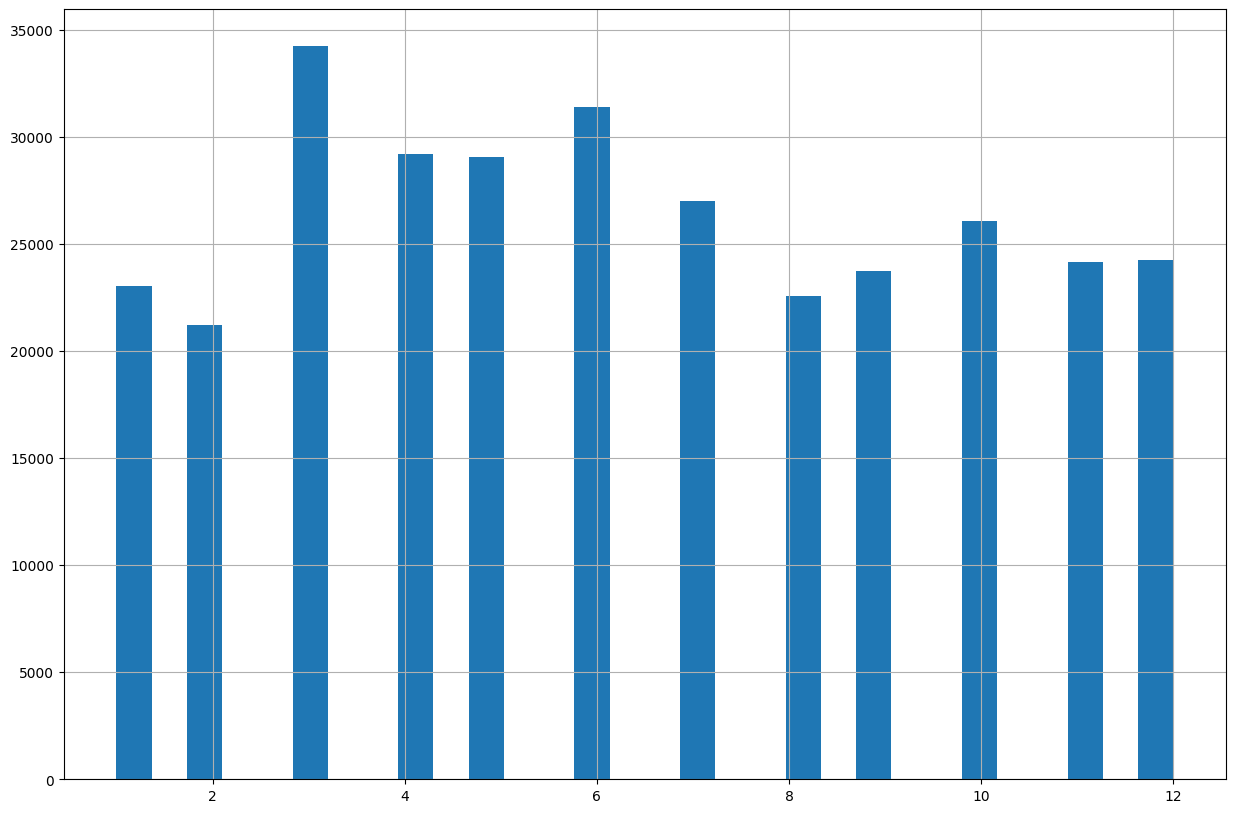

In [5]:
# Removing obvious outliers from 'RegistrationMonth'

car_data = car_data[(car_data['RegistrationMonth'] > 0)]

print(car_data['RegistrationMonth'].describe())

car_data['RegistrationMonth'].hist(bins=30, figsize=(15, 10))

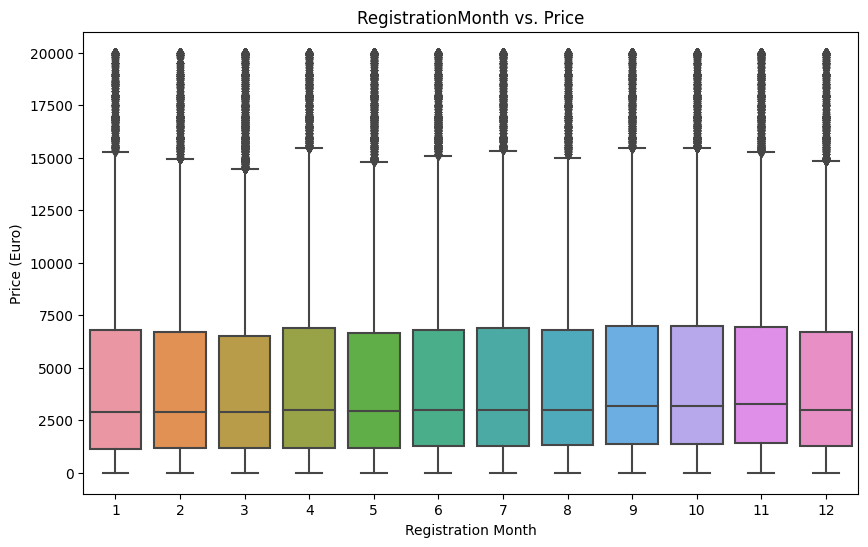

In [6]:
# Visualizing RegistrationMonth vs Price to see if there is a strong correlation
# This was to see if I could remove the RegistrationMonth column entirely

plt.figure(figsize=(10, 6))
sns.boxplot(x='RegistrationMonth', y='Price', data=car_data)
plt.title('RegistrationMonth vs. Price')
plt.xlabel('Registration Month')
plt.ylabel('Price (Euro)')
plt.show()


In [7]:
# There is a lot of missing values


# Checking the columns with missing values in case I could fillna with mean or median
print(car_data['NotRepaired'].unique())
print()
print(car_data['VehicleType'].unique())
print()
print(car_data['FuelType'].unique())
print()
print(car_data['Gearbox'].unique())
print()
print(car_data['Model'].unique())

['yes' nan 'no']

['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' nan 'other']

['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']

['manual' 'auto' nan]

[nan 'grand' 'golf' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa'
 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kangoo' 'corsa'
 'one' 'fortwo' '1er' 'b_klasse' 'astra' 'a8' 'jetta' 'polo' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'a1' 'combo' 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er'
 '80' '147' '100' 'z_reihe' 'sportage' 'sorento' 'v40' 'ibiza' 'mustang'
 'eos' 'touran' 'getz' 'insignia' 'a3' 'ka' 'almera' 'megane' 'lupo' 'r19'
 'zafira' 'mondeo' 'cordoba' 'colt' 'vectra' 'berlingo' 'tiguan' 'espace'
 'sharan' '6_reihe' 'panda' 'up' 'i_reihe' 'seicento' 'ceed' '5_reihe'
 'yeti' 'octavia' 'mii' 'rx_reihe' '6er' 'fox' 'matiz' 'beetle' 'rio'
 'touareg' 'logan' 'caddy' 'sp

In [8]:
# Filling in missing values with their column's mode

nr_mode = car_data['NotRepaired'].mode()[0]
vt_mode = car_data['VehicleType'].mode()[0]
ft_mode = car_data['FuelType'].mode()[0]

car_data['NotRepaired'].fillna(nr_mode, inplace=True)
car_data['VehicleType'].fillna(vt_mode, inplace=True)
car_data['FuelType'].fillna(ft_mode, inplace=True)

print(car_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315846 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        315846 non-null  object
 1   Price              315846 non-null  int64 
 2   VehicleType        315846 non-null  object
 3   RegistrationYear   315846 non-null  int64 
 4   Gearbox            306003 non-null  object
 5   Power              315846 non-null  int64 
 6   Model              303063 non-null  object
 7   Mileage            315846 non-null  int64 
 8   RegistrationMonth  315846 non-null  int64 
 9   FuelType           315846 non-null  object
 10  Brand              315846 non-null  object
 11  NotRepaired        315846 non-null  object
 12  DateCreated        315846 non-null  object
 13  NumberOfPictures   315846 non-null  int64 
 14  PostalCode         315846 non-null  int64 
 15  LastSeen           315846 non-null  object
dtypes: int64(7), object(

In [9]:
# Check for and remove duplicates 

print(car_data.duplicated().sum())

car_data.drop_duplicates(keep='first', inplace=True)
print(car_data.duplicated().sum())

291
0


In [10]:
# Removing rows with missing values

# I did try to remove columns I thought might be 'useless' for predicting price but it just made the models worse, so I added them back
# This is just documentation of me trying that

# List of columns to drop
# columns_to_drop = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth']
# columns_to_drop = ['NumberOfPictures', 'PostalCode'] # This one was for testing

# Remove 'NumberOfPictures'
car_data = car_data.drop(columns= ['NumberOfPictures'])

# Removing missing values and resetting index
car_data.dropna(inplace=True)
car_data.reset_index(drop=True, inplace=True)
print(car_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294027 entries, 0 to 294026
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        294027 non-null  object
 1   Price              294027 non-null  int64 
 2   VehicleType        294027 non-null  object
 3   RegistrationYear   294027 non-null  int64 
 4   Gearbox            294027 non-null  object
 5   Power              294027 non-null  int64 
 6   Model              294027 non-null  object
 7   Mileage            294027 non-null  int64 
 8   RegistrationMonth  294027 non-null  int64 
 9   FuelType           294027 non-null  object
 10  Brand              294027 non-null  object
 11  NotRepaired        294027 non-null  object
 12  DateCreated        294027 non-null  object
 13  PostalCode         294027 non-null  int64 
 14  LastSeen           294027 non-null  object
dtypes: int64(6), object(9)
memory usage: 33.6+ MB
None


In [11]:
# Now we need to convert some columns' datatypes so they can be used for training


# Columns 'DateCrawled', 'DateCreated', and 'LastSeen' are all dates and can be converted to datetime
car_data['DateCrawled'] = pd.to_datetime(car_data['DateCrawled'])
car_data['DateCreated'] = pd.to_datetime(car_data['DateCreated'])
car_data['LastSeen'] = pd.to_datetime(car_data['LastSeen'])

# Extract components since LinearRegression can't use datetime values
car_data['CrawledYear'] = car_data['DateCrawled'].dt.year
car_data['CrawledMonth'] = car_data['DateCrawled'].dt.month
car_data['CrawledDay'] = car_data['DateCrawled'].dt.day
car_data['CrawledDayOfWeek'] = car_data['DateCrawled'].dt.dayofweek
car_data['CrawledHour'] = car_data['DateCrawled'].dt.hour

car_data['CreatedYear'] = car_data['DateCreated'].dt.year
car_data['CreatedMonth'] = car_data['DateCreated'].dt.month
car_data['CreatedDay'] = car_data['DateCreated'].dt.day
car_data['CreatedDayOfWeek'] = car_data['DateCreated'].dt.dayofweek
car_data['CreatedHour'] = car_data['DateCreated'].dt.hour

car_data['LastSeenYear'] = car_data['LastSeen'].dt.year
car_data['LastSeenMonth'] = car_data['LastSeen'].dt.month
car_data['LastSeenDay'] = car_data['LastSeen'].dt.day
car_data['LastSeenDayOfWeek'] = car_data['LastSeen'].dt.dayofweek
car_data['LastSeenHour'] = car_data['LastSeen'].dt.hour

# Drop original datetime columns
car_data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'], inplace=True)


# Convert categorical columns using label encoding
categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    car_data[col] = le.fit_transform(car_data[col])
    label_encoders[col] = le
    
print(car_data.dtypes)

Price                int64
VehicleType          int64
RegistrationYear     int64
Gearbox              int64
Power                int64
Model                int64
Mileage              int64
RegistrationMonth    int64
FuelType             int64
Brand                int64
NotRepaired          int64
PostalCode           int64
CrawledYear          int64
CrawledMonth         int64
CrawledDay           int64
CrawledDayOfWeek     int64
CrawledHour          int64
CreatedYear          int64
CreatedMonth         int64
CreatedDay           int64
CreatedDayOfWeek     int64
CreatedHour          int64
LastSeenYear         int64
LastSeenMonth        int64
LastSeenDay          int64
LastSeenDayOfWeek    int64
LastSeenHour         int64
dtype: object


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Well done!
</div>

## Model training

(I will be putting the slow models into comments so it doesn't take too long to load the whole project)

In [12]:
# Split the data into training and test sets

# Initialize features and target
features = car_data.drop(['Price'], axis=1)
target = car_data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

# LinearRegression:

In [13]:
%%timeit

# Initialize model
linReg = LinearRegression()

# Train model
linReg.fit(features_train, target_train)

# Predict
lin_predictions = linReg.predict(features_test)

# Evaluate the model
lin_rmse = mean_squared_error(target_test, lin_predictions, squared=False)

# Print result
print("Root Mean Squared Error (RMSE):", lin_rmse)

Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
Root Mean Squared Error (RMSE): 3437.9959862146607
529 ms ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# RandomForestRegressor:

In [14]:
# Test to find optimal n_estimators value
# I would have done more but just this took ~20 minutes to run
'''
best_forest2_rmse = 5000
best_est = 5000
for est in range(100, 111):
    forest2 = RandomForestRegressor(random_state=12345, n_estimators=est) # set number of n_estimators
    forest2.fit(features_train, target_train) # train model on training set
    forest2_predictions = forest2.predict(features_test)
    forest2_rmse = mean_squared_error(target_test, forest2_predictions, squared=False) # calculate rmse on test set
    
    if forest2_rmse < best_forest2_rmse:
        best_forest2_rmse = forest2_rmse
        best_est = est

print("Best RMSE score of the best model on the test set (n_estimators = {}): {}".format(best_est, best_forest2_rmse))
'''

'\nbest_forest2_rmse = 5000\nbest_est = 5000\nfor est in range(100, 111):\n    forest2 = RandomForestRegressor(random_state=12345, n_estimators=est) # set number of n_estimators\n    forest2.fit(features_train, target_train) # train model on training set\n    forest2_predictions = forest2.predict(features_test)\n    forest2_rmse = mean_squared_error(target_test, forest2_predictions, squared=False) # calculate rmse on test set\n    \n    if forest2_rmse < best_forest2_rmse:\n        best_forest2_rmse = forest2_rmse\n        best_est = est\n\nprint("Best RMSE score of the best model on the test set (n_estimators = {}): {}".format(best_est, best_forest2_rmse))\n'

Best RMSE score of the best model on the test set (n_estimators = 110): 1657.8453042868964

In [15]:
%%time
'''
# Everytime I tried to run this with the new data the kernal would 'die' after running it for a few minutes
# I've tried a few things but I'm sure the result is the same as before

# Initialize model for speed evaluation
forest2 = RandomForestRegressor(n_estimators=110, random_state=12345)

# Train the model
forest2.fit(features_train, target_train)

# Make predictions
forest2_predictions = forest2.predict(features_test)

# Evaluate
forest2_rmse = mean_squared_error(target_test, forest2_predictions, squared=False)

print(forest2_rmse)
'''

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 7.63 µs


"\n# Everytime I tried to run this with the new data the kernal would 'die' after running it for a few minutes\n# I've tried a few things but I'm sure the result is the same as before\n\n# Initialize model for speed evaluation\nforest2 = RandomForestRegressor(n_estimators=110, random_state=12345)\n\n# Train the model\nforest2.fit(features_train, target_train)\n\n# Make predictions\nforest2_predictions = forest2.predict(features_test)\n\n# Evaluate\nforest2_rmse = mean_squared_error(target_test, forest2_predictions, squared=False)\n\nprint(forest2_rmse)\n"

# LightGBM Regressor:

In [16]:
'''
# Create a basic LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': list(range(290, 311)),  # boosting rounds 
    'max_depth': [18], # maximum tree depth for base learners
    'learning_rate': [0.2] # boosting learning rate
}

# Initialize GridSearchCV with RMSE as the scoring metric
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use negative RMSE (since greater is better for GridSearchCV)
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(features_train, target_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the best model with the best parameters
best_lgb_model = grid_search.best_estimator_

# Make predictions with the best model
lgb_predictions = best_lgb_model.predict(features_test)

# Evaluate the best model
lgb_rmse = mean_squared_error(target_test, lgb_predictions, squared=False)

# Print results
print("Best parameters found: ", best_params)
print("Root Mean Squared Error (RMSE):", lgb_rmse)
'''

'\n# Create a basic LightGBM model\nlgb_model = lgb.LGBMRegressor(random_state=42)\n\n# Define a parameter grid for hyperparameter tuning\nparam_grid = {\n    \'n_estimators\': list(range(290, 311)),  # boosting rounds \n    \'max_depth\': [18], # maximum tree depth for base learners\n    \'learning_rate\': [0.2] # boosting learning rate\n}\n\n# Initialize GridSearchCV with RMSE as the scoring metric\ngrid_search = GridSearchCV(\n    estimator=lgb_model,\n    param_grid=param_grid,\n    scoring=\'neg_root_mean_squared_error\', # Use negative RMSE (since greater is better for GridSearchCV)\n    cv=3,  # Number of cross-validation folds\n    n_jobs=-1,  # Use all available CPUs\n    verbose=2\n)\n\n# Fit the grid search to the data\ngrid_search.fit(features_train, target_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\n\n# Train the best model with the best parameters\nbest_lgb_model = grid_search.best_estimator_\n\n# Make predictions with the best model\nlgb_

*Best parameters found:  {'learning_rate': 0.2, 'max_depth': 18, 'n_estimators': 299}*

*Root Mean Squared Error (RMSE): 1647.553313894596*


For the first grid I did:

n_estimators = [50, 100],

max_depth = list(range(10, 20)),

learning_rate=[.1, .2]

It said the best parameters were learning_rate at .2, max_depth at 14 and n_estimators at 100

That's why I went through and did a couple trials with max_depth at 14 and different n_estimators

After a couple trials I just made the learning rate stay at .2 since that was the best every time

I stopped at 300 n_estimators to avoid overfitting and it becoming too slow, but the rmse was getting better with more n_estimators

I did some more tests for the new data and came up with these parameters

In [17]:
%%timeit

# Initialize lgb model
lgb_model = lgb.LGBMRegressor(n_estimators=299, max_depth=18, learning_rate=0.2, random_state=42)

# Train the model
lgb_model.fit(features_train, target_train)

# Make predictions
lgb_predictions = lgb_model.predict(features_test)

# Evaluate the model
lgb_rmse = mean_squared_error(target_test, lgb_predictions, squared=False)

# Print result
print(lgb_rmse)

1647.5533138945877
1647.5533138945877
1647.553313894596
1647.5533138945877
1647.553313894596
1647.553313894596
1647.553313894596
1647.553313894596
14.6 s ± 1.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good job.
</div>

## Model analysis

# LinearRegression:

%%timeit results: 486 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

~.5 seconds to train and predict, but with a poor rmse

# RandomForest:

%%time results: 

CPU times: user 4min 42s, sys: 990 ms, total: 4min 43s
Wall time: 4min 44s

Four minutes and 40 seconds to train and predict for a rmse of ~1657

# LightGMB:

%%timeit results: 12.1 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

~14 seconds to train and predict with an rmse of ~1647

<div class="alert alert-block alert-danger">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Please make final dataframe with models comparison and recommend the best model for Rusty Bargain.
</div>

<div class="alert alert-block alert-warning">
<b>Overall reviewer's comment</b> <a class="tocSkip"></a>
    
Thank you for sending your project. You've done a really good job on it!

I can note the high level of code and good project structure. 
    
<span class="text-danger"> However, there are some issues. Please check my comments.</span>
    
I believe you can easily fix it!
</div>

In [18]:
data = {
    'Model' : ['LinearRegression', 'RandomForest', 'LightGBM'],
    'Time (seconds)' : [.5, 282, 14],
    'RMSE' : [3437, 1657, 1647]
}

results = pd.DataFrame(data)

print(results)

              Model  Time (seconds)  RMSE
0  LinearRegression             0.5  3437
1      RandomForest           282.0  1657
2          LightGBM            14.0  1647


# Recommendation to Rusty Bargain

Based on the results from the three models evaluated, LightGBM emerges as the preferred choice. It achieves the lowest RMSE value among the models tested, indicating higher predictive accuracy. Additionally, LightGBM demonstrates efficient training and prediction speeds, further solidifying its suitability for the task at hand. Therefore, LightGBM is selected as the model of choice due to its superior performance metrics and efficiency.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed